# Launchpad - Welcome, Predictive Analytics Fundamentals, and Data Workflow

<hr>

<center>
<div>
<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/mgmt_474_ai_logo_02-modified.png" width="200"/>
</div>
</center>

# <center><a class="tocSkip"></center>
# <center>MGMT47400 Predictive Analytics</center>
# <center>Professor: Davi Moreira </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/blob/main/notebooks/01_launchpad_eda_splits.ipynb)

---

## 1. Welcome and Introductions

### 1.1 Your Instructor: Professor Davi Moreira

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/davi_moreira_photo.JPG" width="200" align="center" style="margin-bottom: 10px;">

</div>
</center>

**[Professor Davi Moreira](https://davi-moreira.github.io/)** is a Clinical Assistant Professor at Purdue University's Daniels School of Business. His research focuses on computational social science, machine learning applications in business, data-driven decision making, pedagogy, and AI. He teaches predictive analytics, statistics, and data science courses at both undergraduate and graduate levels.

**Why this course matters:** In today's data-driven business environment, the ability to build, evaluate, and deploy predictive models is essential. Whether you're working in marketing, finance, operations, or strategy, predictive analytics helps you make better decisions, optimize processes, and create competitive advantages.

**What makes this course different:**
- **Hands-on from the start:** Every concept is immediately applied in Google Colab notebooks
- **Real business cases:** We use industry-relevant datasets and scenarios
- **AI-assisted learning:** You'll learn to use Google Gemini responsibly as a coding partner
- **End-to-end workflow:** From raw data to deployed model to business recommendation

<br clear="all">

---

### 1.2 Your Turn: Student Introductions

**PAUSE-AND-DO (5 minutes):**

This is your #0 participation assignment in the course (check the course Brightspace). Please, introduce yourself by answering these questions:

1. **Name and background:** Where are you from? What program are you in?
2. **Data experience:** Have you worked with Python before? Any machine learning exposure?
3. **Goals:** What do you hope to learn or build by the end of this course?
4. **Predictive analytics in your field:** Can you think of one way predictive analytics could be applied in your area of interest? (e.g., predicting customer churn in retail, forecasting stock prices in finance, optimizing supply chains in operations)

---

## 2. Course Syllabus and Logistics

**Note:** Official and detailed syllabus, grading policies, and schedule are available on the course system.

📘 **Course Website:** You can also find additional information in the course website at [https://davi-moreira.github.io/2026Summer_predictive_analytics_purdue_MGMT474/](https://davi-moreira.github.io/2026Summer_predictive_analytics_purdue_MGMT474/)

**Key points covered in the dedicated video:**
- **Course Format:** 4-week intensive, 20 business days, 112.5 min/day commitment.
- **Lecture Structure:** Micro-videos (≤12 min) + Google Colab notebooks + practice exercises.
- **Grading:** Participation (5%), Quizzes (15%), Homework (20%), Midterm (25%), Final Project (35%)
- **Project:** Single capstone with milestones (Proposal, EDA, Baseline Model, Improved Model, Final Submission)
- **Technology:** Google Colab (primary), Google Gemini (AI assistant), Brightspace (LMS)
- **Textbooks:** ISLP (Introduction to Statistical Learning with Python) + supplementary readings

**Daily workflow:**
1. Watch micro-videos (~54 min total)
2. Work through notebook with Participation PAUSE-AND-DO exercises (~40 min)
3. Complete Assignments (~10 min)

---

## 3. Google Colab Setup and Notebook Conventions

### 3.1 Why Google Colab?

**Google Colab** (Colaboratory) is a free, cloud-based Jupyter notebook environment that requires no local setup. It's perfect for this course because:

- ✓ **Zero installation:** No Python setup, no package management, no environment conflicts
- ✓ **Free GPU access:** Useful for deep learning later in the course
- ✓ **Cloud storage:** Work from anywhere, automatic saves to Google Drive
- ✓ **Built-in AI:** Google Gemini integration for coding assistance
- ✓ **Reproducible:** Share notebooks via links, ensure everyone has the same environment

**How to open this notebook in Colab:**
1. Click the "Open in Colab" badge you find at the course brightspace and webpage
2. Or visit: [https://colab.research.google.com/](https://colab.research.google.com/)

---

### 3.2 Colab Navigation and Workflow

**Notebook structure:**
- **Markdown cells:** Text explanations (like this one). Double-click to edit, Shift+Enter to render.
- **Code cells:** Python code that you can run. Click the play button or Shift+Enter to execute.

**Essential keyboard shortcuts:**
- **Shift + Enter:** Run cell and move to next
- **Ctrl + Enter (Cmd + Enter on Mac):** Run cell and stay
- **Ctrl + M B (Cmd + M B):** Insert cell below
- **Ctrl + M A (Cmd + M A):** Insert cell above
- **Ctrl + M D (Cmd + M D):** Delete cell

**Menu options:**
- **Runtime → Run all:** Execute all cells in order (use this to test reproducibility)
- **Runtime → Restart runtime:** Clear all variables and outputs, start fresh
- **File → Save a copy in Drive:** Create your own editable version

**⚠️ Important:** Colab notebooks are **temporary** unless saved to your Drive. Always use "File → Save a copy in Drive" to preserve your work.

---

### 3.3 Course Notebook Conventions

Throughout this course, notebooks follow consistent patterns:

**1. Setup Cell (always first code cell):**
Every notebook starts with imports, random seed, and display settings.

**2. RANDOM_SEED = 474:**
We use seed 474 for all random operations to ensure reproducibility. This means every time you run the notebook, you'll get the same results.

**3. PAUSE-AND-DO Exercises:**
These are 10-minute guided practice sections where you'll apply concepts immediately. Look for this format:

> ## 📝 PAUSE-AND-DO Exercise N (10 minutes)
> **Task:** [What you need to do]  
> **Instructions:** [Step-by-step guidance]

**4. Blockquotes for Critical Rules:**
Important warnings and best practices appear like this:

> ⚠️ **Critical Rule:** Always split data BEFORE preprocessing to avoid leakage.

**5. ✓ Checkmarks for Confirmations:**
When code completes successfully, you'll see: `✓ Setup complete!`

**6. Comments in Code:**
All code includes explanatory comments starting with `#` to help you understand each step.

**7. Google Gemini Integration:**
We'll use Gemini following the **"Ask → Verify → Document"** pattern (explained in Section 3.4).

---

### 3.4 Using Google Gemini Responsibly: The "Ask → Verify → Document" Pattern

**Google Gemini in Colab** is an AI coding assistant integrated directly into your notebooks. It can help you write code, debug errors, and understand concepts. However, **you are responsible for all code you submit**.

**The Three-Step Pattern:**

**1. ASK Gemini to draft code or explain concepts**

Example prompts:
- "Create a histogram of the MedHouseVal variable"
- "Explain what this error message means: KeyError: 'MedHouseVal'"
- "Write code to calculate the correlation between MedInc and MedHouseVal"
- "Generate a scatter plot showing the relationship between Latitude and house values"

**2. VERIFY the code works and you understand it**
- Run the generated code in a cell
- Check the output matches what you expected
- Read through the code line by line
- Ask yourself: "Could I explain what each line does?"

**3. DOCUMENT with your own comments**
- Add `#` comments explaining the logic in your own words
- Annotate any parts that were unclear
- Note any modifications you made

**✓ What's allowed:**
- Using Gemini to generate boilerplate code (imports, data loading, standard plots)
- Asking Gemini to explain error messages or debugging
- Getting suggestions for visualizations or analyses
- Learning new pandas/numpy/sklearn functions

**⚠️ What's required:**
- You must understand **every line** of code you submit
- You must verify that generated code works correctly on your data
- You must add your own comments and documentation
- You must be able to explain your code and methodology

**❌ Accountability:**
- You are responsible for all code you submit, even if Gemini generated it
- If you can't explain your code in the project presentation, you don't understand it well enough
- Gemini can make mistakes - you need to catch them

**Example of proper use with California Housing data:**

```python
# PROMPT TO GEMINI: "Calculate the mean MedHouseVal for coastal vs inland areas"

# Original Gemini output (verified and commented by me):
# Create a binary coastal indicator (Latitude > 37 and Longitude < -120)
df['IsCoastal'] = ((df['Latitude'] > 37) & (df['Longitude'] < -120)).astype(int)

# Group by coastal status and calculate mean house value
mean_price_by_location = df.groupby('IsCoastal')['MedHouseVal'].mean()

# Add my own descriptive print statement
print("Average median house value by location:")
print(f"  Inland (0): ${mean_price_by_location[0]:.2f}00,000")
print(f"  Coastal (1): ${mean_price_by_location[1]:.2f}00,000")

# My interpretation: Coastal areas have significantly higher median house values,
# which makes sense given proximity to ocean and desirable California locations.
```

**Why this matters:** AI tools like Gemini are powerful accelerators, but they don't replace understanding. In business, you need to explain your analyses to stakeholders, defend your methodology, and catch errors. Blindly trusting AI outputs is risky.

---

### 3.5 Let's Test Your Setup

Run the cell below to verify your Colab environment is ready. You should see:
- Python version
- Library versions
- A simple plot
- ✓ Setup confirmation

If you see any errors, use Gemini to help debug!

=== ENVIRONMENT CHECK ===
Python version: 3.11.13
pandas: 3.0.0
numpy: 2.4.2
matplotlib: 3.10.8
seaborn: 0.13.2
scikit-learn: 1.8.0


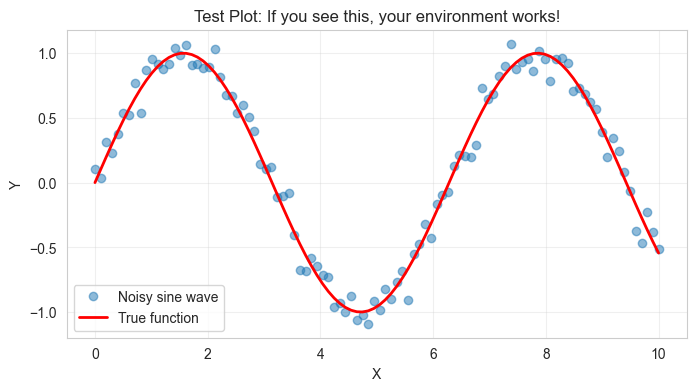


✓ Setup complete! Your Colab environment is ready.
✓ Random seed set to 474 for reproducibility


In [20]:
# Setup Test Cell
# This cell verifies your Colab environment is properly configured

# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn
import sys
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 474
np.random.seed(RANDOM_SEED)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Version check
print("=== ENVIRONMENT CHECK ===")
print(f"Python version: {sys.version.split()[0]}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"scikit-learn: {sklearn.__version__}")

# Create a simple test plot
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, 100)

plt.figure(figsize=(8, 4))
plt.plot(x, y, 'o', alpha=0.5, label='Noisy sine wave')
plt.plot(x, np.sin(x), 'r-', linewidth=2, label='True function')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Test Plot: If you see this, your environment works!')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✓ Setup complete! Your Colab environment is ready.")
print(f"✓ Random seed set to {RANDOM_SEED} for reproducibility")

## 4. Introduction to Predictive Analytics

### 4.1 What is Predictive Analytics? Motivation Examples

**Predictive analytics** is the practice of extracting patterns from historical data to make predictions about future or unknown outcomes. It's used everywhere in modern business and society:

**Example 1: Email Spam Detection**
- **Business problem:** Users receive hundreds of unwanted emails daily, wasting time and risking security
- **Predictive task:** Classify incoming emails as "spam" or "ham" (legitimate)
- **How it works:** Train a model on historical emails labeled as spam/ham; model learns patterns (keywords, sender characteristics, formatting) and predicts labels for new emails
- **Business impact:** Gmail blocks 99.9% of spam, saving billions of user hours annually

**Example 2: Handwritten Digit Recognition (Zip Codes)**
- **Business problem:** US Postal Service processes millions of handwritten envelopes daily; manual sorting is slow and expensive
- **Predictive task:** Read handwritten zip codes from envelope images (0-9 classification)
- **How it works:** Convolutional neural networks trained on thousands of handwritten digit examples
- **Business impact:** Automated mail sorting reduced delivery time and costs by 40%

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/zip_code.png" width="400">

</div>
</center>

*Figure: Handwritten zip code recognition example from USPS automated sorting system.*

**Example 3: Netflix Prize (Movie Recommendations)**
- **Business problem:** Netflix wants to recommend movies users will enjoy to increase engagement and retention
- **Predictive task:** Predict how a user would rate a movie they haven't watched yet
- **How it works:** Collaborative filtering using millions of past user ratings
- **Business impact:** $1M prize competition (2006-2009) improved recommendation accuracy by 10%, resulting in billions in retained subscriptions

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/netflix_prize.png" width="600">

</div>
</center>

*Figure: Netflix Prize leaderboard showing the competition that advanced recommendation systems.*

**Common thread:** All three examples follow the same workflow:
1. Collect historical data with known outcomes
2. Extract relevant features
3. Train a predictive model
4. Deploy the model to make predictions on new data
5. Measure business impact

**This course:** You'll learn the entire workflow, from raw data to deployed model, with emphasis on doing it **correctly** (avoiding leakage, overfitting) and **responsibly** (fairness, transparency).

---

### 4.2 The Machine (Statistical) Learning Framework

At the core of predictive analytics is **machine (statistical) learning:** the set of tools for understanding and modeling relationships between variables.

**The fundamental equation:**

$$Y = f(X) + \epsilon$$

Where:
- **Y:** The outcome variable (target, response, dependent variable) we want to predict
  - Examples: spam/ham label, digit 0-9, movie rating, **house price**
- **X:** The input variables (features, predictors, independent variables) we use to make predictions
  - Examples: email text, pixel intensities, user demographics, **median income, location, house age**
- **f:** The unknown function relating X to Y (this is what we're trying to learn from data)
- **ε (epsilon):** Random error/noise that cannot be predicted (irreducible error)

**Visual intuition using California Housing data:**

We can illustrate $Y = f(X) + \epsilon$ with our California Housing dataset. The plots below show how **Median House Value** relates to three different features — each red curve is our estimate of $f(X)$, and the scatter around it is the noise $\epsilon$:

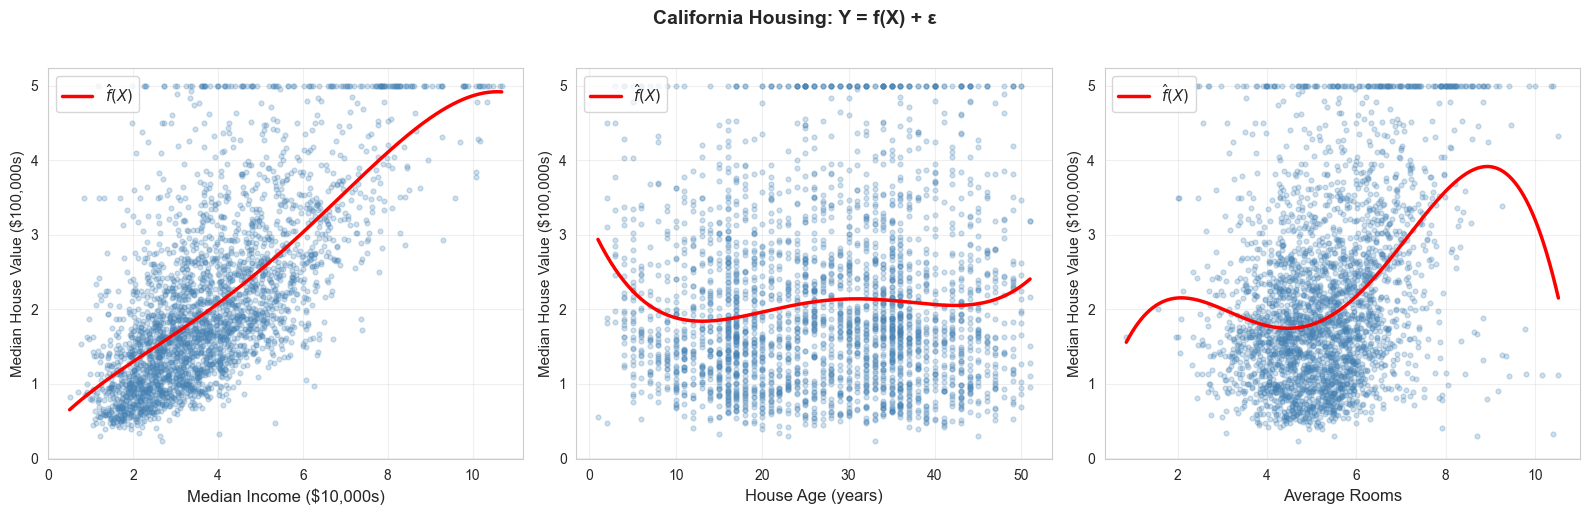

💡 Each red curve represents the estimated f(X) — the systematic relationship
💡 The scatter around the curve represents ε — the irreducible noise
💡 MedInc shows the strongest relationship with MedHouseVal


In [21]:
# Visual Intuition: Y = f(X) + ε using California Housing data
# Here we show MedHouseVal vs. three key features

from sklearn.datasets import fetch_california_housing

california_viz = fetch_california_housing(as_frame=True)
df_viz = california_viz.frame.sample(n=3000, random_state=RANDOM_SEED)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Define features and labels (analogous to ISLP's TV, Radio, Newspaper)
features = ['MedInc', 'HouseAge', 'AveRooms']
labels = ['Median Income ($10,000s)', 'House Age (years)', 'Average Rooms']

for ax, feat, label in zip(axes, features, labels):
    # Filter outliers for cleaner visualization (AveRooms has extreme values)
    mask = df_viz[feat] < df_viz[feat].quantile(0.99)
    x_data = df_viz.loc[mask, feat].values
    y_data = df_viz.loc[mask, 'MedHouseVal'].values

    # Scatter plot (blue dots like ISLP)
    ax.scatter(x_data, y_data, alpha=0.25, s=12, color='steelblue')

    # Smooth trend curve (red line = estimated f(X), like ISLP)
    sort_idx = np.argsort(x_data)
    x_sorted = x_data[sort_idx]
    y_sorted = y_data[sort_idx]

    # Use polynomial fit for smooth curve
    coeffs = np.polyfit(x_sorted, y_sorted, deg=4)
    x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 300)
    y_smooth = np.polyval(coeffs, x_smooth)
    # Clip to data range for visual clarity
    y_smooth = np.clip(y_smooth, 0, 5.5)
    ax.plot(x_smooth, y_smooth, 'r-', linewidth=2.5, label='$\hat{f}(X)$')

    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel('Median House Value ($100,000s)', fontsize=11)
    ax.legend(fontsize=11, loc='upper left')
    ax.grid(True, alpha=0.3)

plt.suptitle('California Housing: Y = f(X) + ε', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("💡 Each red curve represents the estimated f(X) — the systematic relationship")
print("💡 The scatter around the curve represents ε — the irreducible noise")
print("💡 MedInc shows the strongest relationship with MedHouseVal")

Each of the three plots above shows a different "slice" of the relationship $Y = f(X) + \epsilon$. Notice that **Median Income** has the strongest and clearest relationship with house values.

Let's zoom in on that strongest relationship and add a simple linear estimate of $f(X)$:

---

### California Housing Example: Income vs. House Value

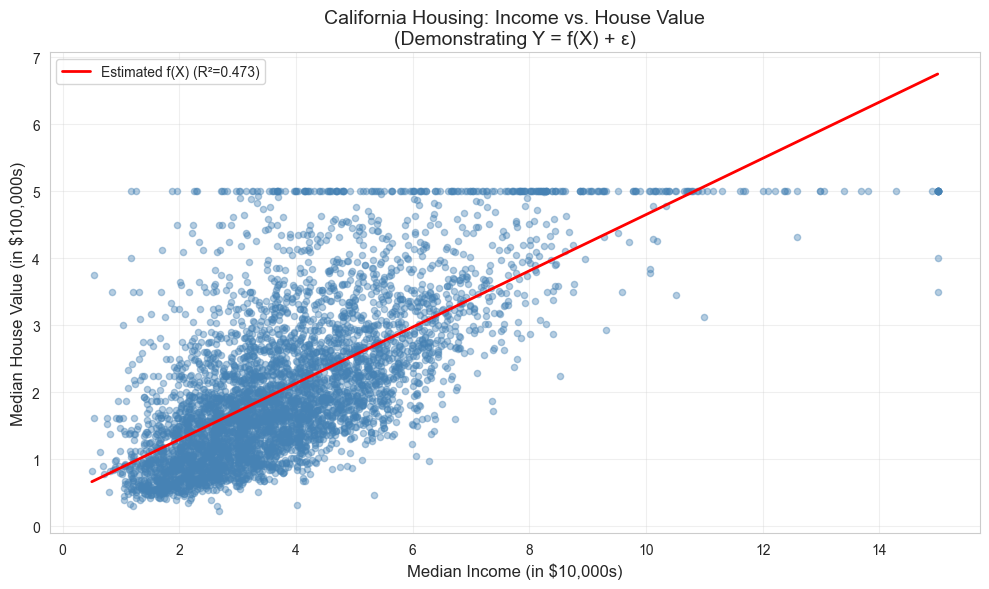

💡 Notice the clear positive relationship: higher income → higher house values
💡 But there's scatter around the red line - that's the 'noise' (ε) we can't eliminate


In [22]:
# Generate California Housing visualization for Statistical Learning Framework
# This demonstrates Y = f(X) + ε using real data

# Load a sample for visualization (use first 5000 points for clearer plot)
from sklearn.datasets import fetch_california_housing
california_demo = fetch_california_housing(as_frame=True)
df_demo = california_demo.frame.sample(n=5000, random_state=474)

# Create scatter plot: MedInc (X) vs MedHouseVal (Y)
plt.figure(figsize=(10, 6))
plt.scatter(df_demo['MedInc'], df_demo['MedHouseVal'], alpha=0.4, s=20, color='steelblue')
plt.xlabel('Median Income (in $10,000s)', fontsize=12)
plt.ylabel('Median House Value (in $100,000s)', fontsize=12)
plt.title('California Housing: Income vs. House Value\n(Demonstrating Y = f(X) + ε)', fontsize=14)
plt.grid(True, alpha=0.3)

# Add a trend line to show f(X)
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df_demo['MedInc'], df_demo['MedHouseVal'])
line_x = np.array([df_demo['MedInc'].min(), df_demo['MedInc'].max()])
line_y = slope * line_x + intercept
plt.plot(line_x, line_y, 'r-', linewidth=2, label=f'Estimated f(X) (R²={r_value**2:.3f})')

plt.legend()
plt.tight_layout()
plt.show()

print(f"💡 Notice the clear positive relationship: higher income → higher house values")
print(f"💡 But there's scatter around the red line - that's the 'noise' (ε) we can't eliminate")

### 4.3 Supervised vs. Unsupervised Learning

**Machine learning** tasks fall into two broad categories:

**Supervised Learning** *(focus of this course)*

**Definition:** We have historical data where the outcome Y is **known** for all training observations. The goal is to learn f(X) so we can predict Y for new observations where it's unknown.

**Two types:**
1. **Regression:** Y is quantitative (continuous number)
   - Examples: predict house price, forecast sales, estimate customer lifetime value
   - Evaluation: mean squared error (MSE), R², mean absolute error (MAE)

2. **Classification:** Y is qualitative (discrete category)
   - Examples: spam/ham, churn/stay, approve/deny loan, diagnose disease
   - Evaluation: accuracy, precision, recall, ROC AUC

**Key point:** We train on **labeled data** (X and Y pairs) and deploy the model to predict Y for unlabeled data (just X).

---

**Unsupervised Learning** *(not covered in this course)*

**Definition:** We only have X (features), no outcome Y. The goal is to discover structure, patterns, or groupings in the data.

**Common tasks:**
- **Clustering:** Group similar observations together
  - Example: segment customers into personas based on demographics and behavior
- **Dimensionality reduction:** Compress high-dimensional data while preserving information
  - Example: visualize high-dimensional product reviews in 2D
- **Anomaly detection:** Find unusual observations
  - Example: detect fraudulent transactions

**Why unsupervised is harder:** No "correct answer" to check against, so evaluation is subjective.

**This course:** We focus exclusively on **supervised learning** (regression and classification) because these are the most common business applications of predictive analytics.

---

### 4.4 End-to-End Predictive Modeling Workflow

**Real-world predictive analytics projects** follow a structured workflow with 9 core steps. Let's preview the journey using our **California Housing price prediction** problem.

**Business Problem:** A California real estate investment firm identifies undervalued properties by comparing predicted market values to listing prices. Currently, manual appraisals cost $500-$1,000 per property and take 2-3 weeks. The firm wants a predictive model that can estimate median house values instantly from publicly available census data, enabling faster and cheaper investment decisions.

**Target Variable (Y):** `MedHouseVal` (continuous: median house value in $100,000s)  
**Features (X):** Location (Latitude, Longitude), demographics (MedInc, Population, AveOccup), and housing stock (HouseAge, AveRooms, AveBedrms)

---

**Step 0: Setup and Configuration**
- Import libraries (pandas, numpy, matplotlib, scikit-learn)
- Set random seed for reproducibility (`RANDOM_SEED = 474`)
- Configure display settings

**Step 1: Data Loading and Sanity Checks**
- Load California Housing dataset from sklearn (20,640 census block groups)
- Validate data types, shapes, and ranges
- Confirm all 8 features are numeric and no ID columns need removal
- Verify target variable `MedHouseVal` is continuous (regression problem)

**Step 2: Exploratory Data Analysis (EDA)**
- Examine target distribution (right-skewed, capped at $500,000)
- Analyze feature distributions (MedInc is right-skewed, HouseAge is roughly uniform)
- Explore bivariate relationships (scatter plots of features vs. house value)
- Compute correlation matrix
- **Business insight:** Median income (MedInc) is the strongest predictor of house value (r ≈ 0.69); geographic location also matters significantly

**Step 3: Data Preparation and Feature Engineering**
- Handle outliers (AveRooms and AveOccup have extreme values)
- Scale numeric features (standardization so all features are on comparable scales)
- Optionally create new features (e.g., rooms-per-bedroom ratio, coastal indicator)
- Build a preprocessing pipeline to ensure reproducibility and prevent leakage

**Step 4: Baseline Model**
- Train simple linear regression (interpretable, fast)
- Evaluate with cross-validation (MAE, RMSE, R²)
- Establish performance benchmark
- **Baseline MAE:** ~$52,000 (MAE ≈ 0.52 in $100,000s)

**Step 5: Advanced Models**
- Try regularized regression (Ridge, LASSO) to handle multicollinearity
- Try tree-based methods (Decision Tree, Random Forest) to capture non-linearities
- Tune hyperparameters using validation set or cross-validation
- **Best model MAE:** ~$33,000 (Random Forest with tuned hyperparameters)

**Step 6: Model Comparison and Visualization**
- Plot MAE and RMSE across all models with confidence intervals
- Create comparison table (MAE, RMSE, R², number of features used)
- Visualize predicted vs. actual house values (scatter plot, residual plot)

**Step 7: Model Selection and Rationale**
- Choose best model based on performance, stability, and business needs
- Consider interpretability: can we explain to stakeholders why a property is valued at $X?
- Document decision criteria transparently

**Step 8: Final Training**
- Retrain selected model on **full training data** (train + validation)
- Save model artifact (`.joblib` file)
- Record metadata (timestamp, features, hyperparameters, performance metrics)

**Step 9: Test Set Predictions and Submission**
- Load held-out test data (untouched until now)
- Generate predictions (estimated median house values)
- Evaluate final performance on test set (one-time use only)
- Export predictions for business use

**Step 99: Reporting and Reproducibility**
- Write `requirements.txt` for package versions
- Document assumptions and limitations (e.g., data is from 1990 census, capped at $500k)
- Create executive summary: "The model predicts median house values with an average error of ~$33,000, enabling the firm to screen properties 100× faster than manual appraisals"

---

**Key principles throughout:**
- ✓ **Split first, preprocess second:** Avoid leakage by separating data before any transformations
- ✓ **Use cross-validation:** Don't trust a single train/test split; average performance across multiple folds
- ✓ **Lock the test set:** Don't peek at test data until final evaluation (one-time use only)
- ✓ **Document everything:** Future you (and your stakeholders) need to understand your choices
- ✓ **Reproducibility matters:** Set seeds (RANDOM_SEED = 474), version packages, save pipelines

**In this notebook:** We'll practice Steps 0-2 (setup, EDA, splitting). Future notebooks will cover Steps 3-9.

---

### 4.5 Data Leakage: The Silent Killer of Predictive Models

**Data leakage** occurs when information from outside the training dataset unintentionally "leaks" into the model, causing it to perform well during development but fail catastrophically in production.

**Why it's dangerous:**
- Your model will show excellent performance on validation data (high AUC, low error)
- You'll deploy the model thinking it works
- In production, performance will collapse because the leaked information isn't available for new predictions
- **Business impact:** Wasted resources, lost revenue, damaged credibility

**Two types of leakage:**

---

**Type 1: Target Leakage**

**Definition:** A predictor includes information that will not be available at the time you need to make a prediction.

**Example 1 - Pneumonia Prediction (from Kaggle tutorial):**
- **Task:** Predict which patients admitted to the hospital have pneumonia
- **Leaked feature:** `got_antibiotic` (whether patient received antibiotics)
- **Problem:** Antibiotics are prescribed **after** diagnosis. The feature encodes the target directly.
- **Result:** Model shows 99% accuracy in validation, but in production you don't know if a newly admitted patient will get antibiotics (that's what you're trying to predict!).

**Example 2 - Customer Churn:**
- **Task:** Predict which customers will close accounts next month
- **Leaked feature:** `num_service_calls_next_month` (how many times customer called support next month)
- **Problem:** This data doesn't exist yet when you make the prediction.
- **Result:** Model learns that customers with many calls next month churn, but you can't know future call volume.

**How to detect target leakage:**
- Ask: "Will this feature be available at prediction time?"
- Check for suspiciously high correlations between a feature and the target (r > 0.9)
- Think about temporal order: does the feature come before or after the outcome?

---

**Type 2: Train-Test Contamination**

**Definition:** Information from the validation or test set influences the training process, causing overly optimistic performance estimates.

**Example 1 - Preprocessing Leakage:**
```python
# WRONG: Standardize before splitting
X_scaled = StandardScaler().fit_transform(X)  # Uses ALL data including test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

# Problem: Mean and std from test set influenced training data scaling
```

**Correct approach:**
```python
# RIGHT: Split first, then fit scaler only on training data
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler().fit(X_train)  # Learn from train only
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Apply learned parameters
```

**Example 2 - Feature Selection Leakage:**
- **Wrong:** Compute feature correlations on full dataset, then split
- **Right:** Split first, then compute correlations only on training data

**Example 3 - Hyperparameter Tuning Leakage:**
- **Wrong:** Use test set to choose between models or tune hyperparameters
- **Right:** Use cross-validation on training set; lock test set until final evaluation

---

**The Golden Rule to Prevent Leakage:**

> **⚠️ Split first, preprocess second, model third**

**Workflow that prevents contamination:**
1. **Split** data into train/validation/test **before any analysis**
2. **EDA and preprocessing** should be fitted on training data only
3. **Modeling and evaluation** use cross-validation within training data
4. **Test set** is opened exactly once at the end for final performance estimate

**Additional leakage prevention checklist:**
- [ ] Remove ID columns and names (can encode target information)
- [ ] Check feature descriptions for future information
- [ ] Verify temporal alignment (features collected before outcome)
- [ ] Use pipelines to ensure preprocessing is part of cross-validation
- [ ] Never look at test set until final evaluation

**Real-world impact:** Kaggle competitions have been won and lost based on proper leakage prevention. In business, a leaky model can cost millions in bad decisions.

**Further reading:** [Kaggle Data Leakage Tutorial](https://www.kaggle.com/code/alexisbcook/data-leakage)

---

### 4.6 Assessing Model Accuracy: Train vs. Test Error

**Question:** How do we know if our model $\hat{f}(X)$ is any good?

**Naive approach:** Compute prediction error on the training data:

$$\text{MSE}_{\text{train}} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{f}(x_i))^2$$

**Problem:** Training error is **optimistically biased**. As model complexity increases, training error always decreases (even if the model is overfitting).

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_6-1.png" width="500">

</div>
</center>

*Figure: A highly flexible spline fits every training point perfectly (MSE = 0), but this is **overfitting** - the model won't generalize to new data.*

---

**Better approach:** Use fresh **test data** that the model has never seen:

$$\text{MSE}_{\text{test}} = \frac{1}{m} \sum_{i=1}^{m} (y_i^{\text{test}} - \hat{f}(x_i^{\text{test}}))^2$$

**Key insight:** Test error measures **generalization** - how well the model performs on new data from the same population.

**What we want:** A model that minimizes **test error**, not training error.

**The fundamental trade-off:**
- Simple models (e.g., linear regression) may have high training error but generalize well (low test error)
- Complex models (e.g., deep neural networks) can have zero training error but poor test error (overfitting)

**Goal of this course:** Learn to build models that generalize well by:
1. Using proper train/validation/test splits
2. Employing cross-validation for robust evaluation
3. Understanding the bias-variance trade-off (next section)
4. Preventing overfitting through regularization

---

### 4.7 The Curse of Dimensionality

**Question:** Why can't we just use more features to make better predictions?

**Intuition:** In high dimensions, data becomes sparse, and "similar" observations become rare. This makes pattern recognition exponentially harder.

**Visual demonstration:**

<center>
<div>


<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_1_4_1.png" width="350">

</div>
</center>

<br>

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_1_4_2.png" width="350">

</div>
</center>

*Figure: To capture 10% of data points in 1D, we need a small interval. In 2D, we need a much larger circle. As dimensions increase, the "neighborhood" explodes.*

**The mathematical problem:**

Suppose we want to predict Y using K-Nearest Neighbors by averaging the 10% closest training points:

- **1 dimension (p=1):** If we have 100 points, we need to extend ±5 units to capture 10
- **2 dimensions (p=2):** Need a circle with radius ~18 to capture 10 points (area grows as r²)
- **10 dimensions (p=10):** Need a hypersphere with radius ~80 (volume grows as r¹⁰)

**Bottom panel in figures above:** As dimensionality increases, neighborhoods must expand dramatically to capture the same fraction of points. In 10 dimensions, even capturing 1% of data requires looking across 80% of the feature space!

**Practical implications:**

1. **Data sparsity:** In high dimensions, all points are far apart. "Nearest neighbors" aren't actually nearby.
2. **Overfitting:** Models have too much flexibility relative to available data, memorizing noise instead of learning patterns.
3. **Computational cost:** Algorithms that search neighborhoods (KNN, kernel methods) become prohibitively slow.

**Solutions:**

- **Feature selection:** Keep only the most predictive features
- **Dimensionality reduction:** PCA, autoencoders compress high-dimensional data
- **Regularization:** Penalize model complexity (LASSO, Ridge)
- **Parametric models:** Linear models assume structure, reducing effective dimensionality

**Rule of thumb:** You need exponentially more data as the number of features grows. With 10 features and 100 samples, you're in good shape. With 1000 features and 100 samples, you're in trouble.

**This course:** We'll learn feature selection techniques to combat the curse of dimensionality.

---

### 4.8 Flexibility vs. Interpretability Trade-off

**Question:** Should we use simple or complex models?

**Answer:** It depends on your goals and constraints.

**The spectrum:**

<center>
<div>


<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_7-1.png" width="600">

</div>
</center>

*Figure: Different models trade off flexibility (ability to fit complex patterns) with interpretability (ability to explain predictions).*

---

**Left side: High Interpretability, Low Flexibility**

**Linear Models:**
$$\hat{Y} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p$$

**Pros:**
- Coefficients β directly quantify feature importance and direction of effect
- Easy to explain to non-technical stakeholders
- Fast to train and predict
- Less prone to overfitting

**Cons:**
- Can't capture non-linear relationships or interactions
- May underfit if true relationship is complex

**When to use:** Regulatory environments (lending, healthcare), need to explain decisions, small datasets

---

**Middle: Moderate Flexibility and Interpretability**

**Tree-based Models (Decision Trees, Random Forests):**
- Pros: Handle non-linearities and interactions, feature importance scores, visual decision rules
- Cons: Can overfit (single trees), hard to interpret individual predictions (forests)

**Generalized Additive Models (GAMs):**
- Pros: Capture non-linearities while maintaining some interpretability
- Cons: Don't automatically capture interactions

**When to use:** Exploratory analysis, moderate-sized datasets, need balance of accuracy and explainability

---

**Right side: High Flexibility, Low Interpretability**

**Deep Neural Networks, Gradient Boosting (XGBoost, LightGBM):**

**Pros:**
- Can learn extremely complex patterns
- Often achieve best predictive accuracy
- Handle high-dimensional data

**Cons:**
- "Black box" - hard or impossible to explain individual predictions
- Require large datasets and careful tuning
- Slow to train
- Easy to overfit

**When to use:** Image/text/speech data, large datasets, prediction accuracy is paramount, don't need to explain decisions

---

**Practical guidance:**

**Start simple:** Always begin with logistic regression or a simple tree. This establishes a baseline and helps you understand the data.

**Add complexity only if needed:** If the simple model performs well enough for the business problem, stop there. Explainability is valuable.

**Use interpretability tools:** Even for complex models, SHAP values and partial dependence plots can provide some explanation.

**Consider the stakes:** High-risk decisions (medical diagnosis, loan approval) require more interpretability than low-risk ones (movie recommendations).

**This course:** We'll cover the full spectrum, but emphasize interpretable models (linear, regularized regression, trees) since these are most common in business analytics.

---

### 4.9 The Bias-Variance Trade-off

**The most important concept in predictive modeling:** Understanding why models fail and how to fix them.

**Test error decomposition:**

$$\mathbb{E}[(Y - \hat{f}(X))^2] = \underbrace{(\text{Bias}[\hat{f}(X)])^2}_{\text{underfitting}} + \underbrace{\text{Var}[\hat{f}(X)]}_{\text{overfitting}} + \underbrace{\sigma^2}_{\text{irreducible}}$$

Three components:

---

**1. Bias²: Error from Wrong Assumptions (Underfitting)**

**Definition:** The error introduced by approximating a complex real-world problem with a simplified model.

**High bias means:**
- Model is too rigid
- Misses important patterns (systematic error)
- **Underfits** the training data

**Example:** Using a straight line to fit a curved relationship

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_1_5.png" width="400">

</div>
</center>

*Figure: Linear model (high bias) misses the curvature in the data.*

**Typical causes:**
- Overly simple model (linear when should be non-linear)
- Too few features
- Heavy regularization

**How to detect:** Both training and test error are high

**How to fix:** Add features, increase model complexity, reduce regularization

---

**2. Variance: Error from Sensitivity to Training Data (Overfitting)**

**Definition:** The amount by which the model's predictions would change if we trained on a different sample from the same population.

**High variance means:**
- Model is too flexible
- Overly sensitive to noise in training data
- **Overfits** by memorizing training examples

**Example:** High-degree polynomial fits training data perfectly but wiggles wildly

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_6-1.png" width="400">

</div>
</center>

*Figure: Very flexible spline (high variance) fits every training point but doesn't generalize.*

**Typical causes:**
- Overly complex model
- Too many features relative to sample size
- No regularization

**How to detect:** Training error is low, but test error is high (large gap)

**How to fix:** Simplify model, remove features, add regularization, get more training data

---

**3. Irreducible Error σ²: Random Noise**

**Definition:** Variability in Y that cannot be explained by X, no matter how good our model is.

**Sources:**
- Measurement error
- Omitted variables (factors affecting Y that aren't in X)
- True randomness in the process

**Key point:** This sets a lower bound on test error. No amount of modeling can reduce it.

---

**Visualizing the Trade-off:**

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_9-1-1.png" width="400">

</div>
</center>

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_9-1-2.png" width="400">

</div>
</center>

**Top panel:** Three fitted models with different flexibility
- **Orange (low flexibility):** High bias (misses pattern), low variance (stable)
- **Blue (medium flexibility):** Balanced bias and variance (best)
- **Green (high flexibility):** Low bias (captures pattern), high variance (overfits noise)

**Bottom panel:** Error curves vs. model flexibility
- **Gray (training error):** Monotonically decreases as flexibility increases
- **Red (test error):** U-shaped - decreases initially, then increases due to overfitting
- **Sweet spot:** Minimum test error (blue vertical line) balances bias and variance

---

**The Trade-off:**

As model flexibility increases:
- **Bias decreases** (better fit to training data)
- **Variance increases** (more sensitive to training sample)

**Goal:** Choose complexity that **minimizes expected test error** by balancing bias and variance.

---

**Different scenarios:**

<center>
<div>


<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_10-1.png" width="400">

</div>
</center>

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_11-1.png" width="400">

</div>
</center>

**Left:** True relationship is smooth → simpler models perform well  
**Right:** True relationship is wiggly → more flexible models needed

**Lesson:** Optimal model complexity depends on the problem. There's no universal "best" model.

---

**Decomposition across complexities:**

<center>
<div>

<img src="https://raw.githubusercontent.com/davi-moreira/2026Summer_predictive_analytics_purdue_MGMT474/main/notebooks/figures/2_12-1.png" width="700">

</div>
</center>

*Figure: Test MSE (red) = Squared Bias (blue) + Variance (orange) + Irreducible Error (dotted). The sweet spot (vertical line) minimizes test error.*

---

**Practical implications:**

**Tools to manage the trade-off:**
1. **Cross-validation:** Estimate test error without touching test set
2. **Regularization:** Constrain model complexity (LASSO, Ridge, Elastic Net)
3. **Ensemble methods:** Reduce variance by averaging many models (Random Forest, Bagging)
4. **Early stopping:** Stop training before overfitting (neural networks)
5. **Feature selection:** Remove irrelevant features that add variance without reducing bias

**This course:** Every modeling decision we make (train/val/test splits, cross-validation, hyperparameter tuning, regularization) is about managing the bias-variance trade-off.

**Key takeaway:** Understanding this trade-off is the difference between building models that work in notebooks vs. models that work in production.

---

## 5. Hands-On Practice: California Housing Price Prediction EDA and Splitting

Now that we understand the theory, let's apply it to a **real regression problem**.

### 5.1 Business Case: California Housing Price Prediction

**Business Context:**

You are a data analyst at a California real estate investment firm. The firm makes money by identifying undervalued properties, purchasing them, and either renting them out or reselling them at a profit. Accurate price predictions are crucial for two key decisions:

1. **Investment decisions:** Which properties should the firm buy? (those priced below predicted value)
2. **Portfolio valuation:** What is the current market value of the firm's existing properties?

Currently, the firm relies on manual appraisals that are expensive ($500-$1000 per property) and slow (2-3 weeks turnaround). Your task is to build a **predictive model** that can estimate house prices instantly based on property characteristics and location.

**Your task:** Build a regression model that predicts median house values for California census block groups.

**Target Variable:** `MedHouseVal` (continuous, measured in $100,000s)
- **Range:** Typically $0.15 to $5.0 (representing $15,000 to $500,000)
- **Interpretation:** Median house value for houses within a census block group

**Available Features:**
- **Location:** Latitude, Longitude (geographic coordinates)
- **Demographics:** MedInc (median income in block group, in $10,000s), Population, AveOccup (average occupancy)
- **Housing Stock:** HouseAge (median age of houses), AveRooms (average rooms per household), AveBedrms (average bedrooms per household)

**Success Metrics:**
- **Primary:** MAE (Mean Absolute Error) - average prediction error in $100,000s
  - **Why MAE?** Directly interpretable in business terms ("on average, we're off by $X")
- **Secondary:** RMSE (Root Mean Squared Error) - penalizes large errors more heavily
  - **Why RMSE?** Buying a house at 2× overpayment is worse than 2× small errors

**Business Constraint:** The firm can tolerate prediction errors up to $50,000 (MAE < 0.5) for most properties, but large errors ($100,000+) on expensive properties could be financially disastrous. Model must balance overall accuracy with avoiding catastrophic mispredictions.

---

### 5.2 Load the Data from sklearn and Save as CSV

We'll use the California Housing dataset from sklearn, which is a classic regression benchmark. We'll demonstrate how to save and reload it as a CSV file for reproducibility.

In [23]:
# Step 1: Load California Housing dataset from sklearn
from sklearn.datasets import fetch_california_housing

# Fetch the dataset as a pandas DataFrame
california = fetch_california_housing(as_frame=True)
df_full = california.frame

print("=== DATASET LOADED FROM SKLEARN ===")
print(f"Shape: {df_full.shape[0]} rows × {df_full.shape[1]} columns")
print(f"\nColumn names:")
print(df_full.columns.tolist())
print(f"\nFirst 5 rows:")
display(df_full.head())

# Step 2: Save to CSV (demonstrating data persistence)
csv_path = 'california_housing.csv'
df_full.to_csv(csv_path, index=False)
print(f"\n✓ Dataset saved to: {csv_path}")

# Step 3: Reload from CSV (simulating real-world workflow)
df = pd.read_csv(csv_path)
print(f"\n✓ Dataset reloaded from CSV")
print(f"Reloaded shape: {df.shape}")

# Verify target variable
print(f"\n=== TARGET VARIABLE ===")
print(f"Target: 'MedHouseVal' (Median House Value in $100,000s)")
print(f"Type: Continuous (Regression problem)")
print(f"Range: {df['MedHouseVal'].min():.2f} to {df['MedHouseVal'].max():.2f}")
print(f"Mean: ${df['MedHouseVal'].mean():.2f}00,000")
print(f"Median: ${df['MedHouseVal'].median():.2f}00,000")

=== DATASET LOADED FROM SKLEARN ===
Shape: 20640 rows × 9 columns

Column names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

First 5 rows:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.325,41.0,6.984,1.024,322.0,2.556,37.88,-122.23,4.526
1,8.301,21.0,6.238,0.972,2401.0,2.110,37.86,-122.22,3.585
2,7.257,52.0,8.288,1.073,496.0,2.802,37.85,-122.24,3.521
3,5.643,52.0,5.817,1.073,558.0,2.548,37.85,-122.25,3.413
4,3.846,52.0,6.282,1.081,565.0,2.181,37.85,-122.25,3.422



✓ Dataset saved to: california_housing.csv

✓ Dataset reloaded from CSV
Reloaded shape: (20640, 9)

=== TARGET VARIABLE ===
Target: 'MedHouseVal' (Median House Value in $100,000s)
Type: Continuous (Regression problem)
Range: 0.15 to 5.00
Mean: $2.0700,000
Median: $1.8000,000


### 5.3 Identify Features and Target

**Critical step:** Before EDA, we must clearly identify our target variable and feature set.

**Target Variable:** `MedHouseVal` - This is what we want to predict

**Features:** All other columns represent potential predictors:
- **MedInc:** Median income in block group
- **HouseAge:** Median house age in block group
- **AveRooms:** Average number of rooms per household
- **AveBedrms:** Average number of bedrooms per household
- **Population:** Block group population
- **AveOccup:** Average household occupancy
- **Latitude:** Latitude coordinate
- **Longitude:** Longitude coordinate

**No ID columns to remove:** Unlike many business datasets, California Housing is already clean with no row numbers or customer IDs that need to be excluded.

Let's verify the data structure:

In [24]:
# Verify dataset structure
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"\nAll columns:")
for idx, col in enumerate(df.columns, 1):
    print(f"  {idx}. {col}")

# Separate target from features
target_col = 'MedHouseVal'
feature_cols = [col for col in df.columns if col != target_col]

print(f"\n=== MODELING SETUP ===")
print(f"Target variable: {target_col}")
print(f"Number of features: {len(feature_cols)}")
print(f"Feature list: {feature_cols}")

# Basic statistics on target
print(f"\n=== TARGET DISTRIBUTION ===")
print(df[target_col].describe())
print(f"\nInterpretation:")
print(f"  - Median house values range from ${df[target_col].min():.2f}00,000 to ${df[target_col].max():.2f}00,000")
print(f"  - Average median value: ${df[target_col].mean():.2f}00,000")
print(f"  - Standard deviation: ${df[target_col].std():.2f}00,000")
print(f"\n✓ This is a REGRESSION problem (predicting continuous values)")

=== DATASET OVERVIEW ===
Shape: (20640, 9)

All columns:
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveBedrms
  5. Population
  6. AveOccup
  7. Latitude
  8. Longitude
  9. MedHouseVal

=== MODELING SETUP ===
Target variable: MedHouseVal
Number of features: 8
Feature list: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

=== TARGET DISTRIBUTION ===
count    20640.000
mean         2.069
std          1.154
min          0.150
25%          1.196
50%          1.797
75%          2.647
max          5.000
Name: MedHouseVal, dtype: float64

Interpretation:
  - Median house values range from $0.1500,000 to $5.0000,000
  - Average median value: $2.0700,000
  - Standard deviation: $1.1500,000

✓ This is a REGRESSION problem (predicting continuous values)


## 6. EDA Checklist: Types, Missingness, Target Distribution

### 6.1 Data Types Audit

First, let's understand what types of data we're working with.

In [25]:
# Check data types
print("=== DATA TYPES ===")
print(df.dtypes)
print("\n=== DATA INFO ===")
df.info()

=== DATA TYPES ===
MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

=== DATA INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


**Reading the output:**

All 9 columns (8 features + 1 target) are `float64` — this is ideal for scikit-learn, which expects numeric inputs. The `df.info()` table confirms **20,640 rows** with **zero null values** across every column, and the DataFrame uses about **1.4 MB** of memory.

**Why this matters:** No type conversions or categorical encoding are needed. We can pass these features directly into a scikit-learn pipeline. In many real-world datasets you will encounter `object` (string) columns or mixed types that require cleaning — here the data is already in model-ready numeric form.

---

### 6.2 Missingness Check

In [26]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
})

print("=== MISSING VALUES ===")
if missing.sum() == 0:
    print("✓ No missing values detected!")
else:
    print(missing_df[missing_df['Missing_Count'] > 0])

=== MISSING VALUES ===
✓ No missing values detected!


**Reading the output:**

The check confirms **zero missing values** across all 9 columns. This is unusual — most real-world business datasets have some missingness due to incomplete records, sensor failures, or optional survey fields.

The California Housing dataset is pre-cleaned by scikit-learn, so we can skip imputation entirely for this notebook. In your **course project**, you will likely encounter missing data and will need strategies such as mean/median imputation, indicator columns for missingness, or more sophisticated approaches.

---

### 6.3 Basic Descriptive Statistics

In [27]:
# Descriptive statistics
print("=== DESCRIPTIVE STATISTICS ===")
df.describe()

=== DESCRIPTIVE STATISTICS ===


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000,20640.000,20640.000,20640.000,20640.000,20640.000,20640.000,20640.000,20640.000
mean,3.871,28.639,5.429,1.097,1425.477,3.071,35.632,-119.570,2.069
std,1.900,12.586,2.474,0.474,1132.462,10.386,2.136,2.004,1.154
min,0.500,1.000,0.846,0.333,3.000,0.692,32.540,-124.350,0.150
25%,2.563,18.000,4.441,1.006,787.000,2.430,33.930,-121.800,1.196
50%,3.535,29.000,5.229,1.049,1166.000,2.818,34.260,-118.490,1.797
75%,4.743,37.000,6.052,1.100,1725.000,3.282,37.710,-118.010,2.647
max,15.000,52.000,141.909,34.067,35682.000,1243.333,41.950,-114.310,5.000


**Reading the output:**

The `describe()` table reveals several important patterns:

1. **Scale differences are large:** MedInc ranges from 0.5 to 15, while Population ranges from 3 to 35,682. Features on very different scales will cause problems for distance-based models (KNN) and regularized models (Ridge, LASSO), so **feature scaling** will be needed in later notebooks.

2. **Extreme outliers exist:** AveRooms has a max of 141.9 versus a median of 5.2, and AveOccup has a max of 1,243 versus a median of 2.8. These extreme values likely come from block groups with very small populations, where averages become unstable. We may need to cap or remove these outliers during preprocessing.

3. **Ceiling effects in the data:** HouseAge maxes out at 52 (a census truncation — houses older than 52 are all recorded as 52). MedHouseVal is capped at 5.0 (\$500,000) — block groups where the true median exceeds \$500k are all recorded at exactly 5.0. This cap limits our model's ability to predict high-value areas accurately.

4. **Geographic scope:** Latitude (32.5–42.0) and Longitude (-124.4 to -114.3) span the full state of California, from San Diego in the south to near the Oregon border.

---

### 6.4 Target Distribution (Regression)

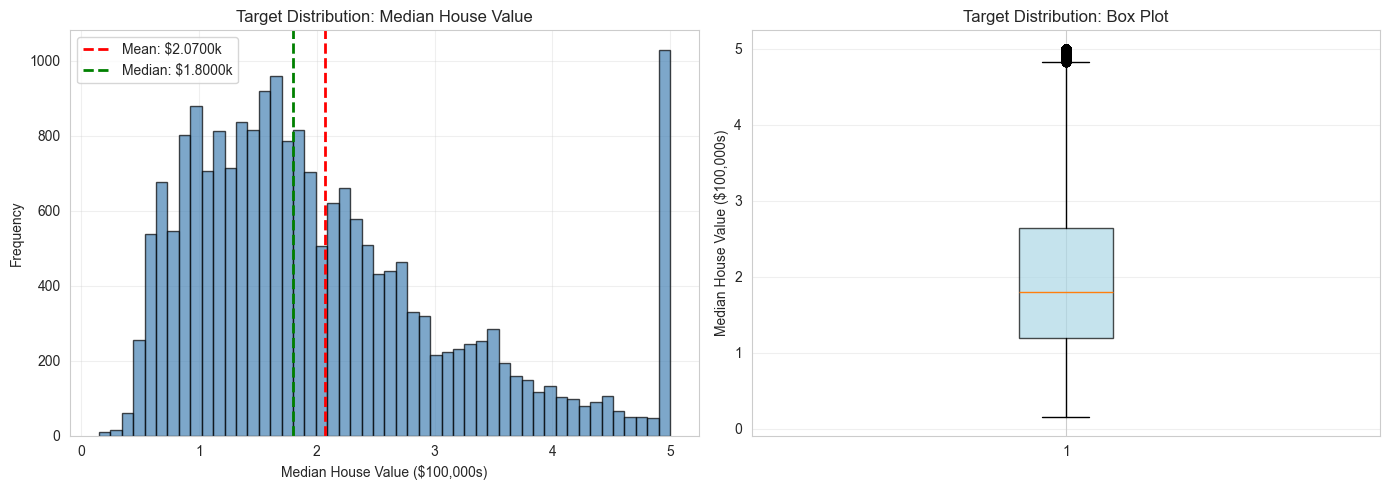

=== TARGET STATISTICS ===
Count: 20640
Mean: $2.0700,000
Median: $1.8000,000
Std Dev: $1.1500,000
Min: $0.1500,000
Max: $5.0000,000

💡 Key observations:
  - Distribution is right-skewed (mean > median)
  - Some high-value outliers visible in box plot
  - This is typical for real estate prices


In [28]:
# Visualize target distribution for regression
target_col = 'MedHouseVal'

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df[target_col], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df[target_col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df[target_col].mean():.2f}00k')
axes[0].axvline(df[target_col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${df[target_col].median():.2f}00k')
axes[0].set_xlabel('Median House Value ($100,000s)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution: Median House Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df[target_col], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Median House Value ($100,000s)')
axes[1].set_title('Target Distribution: Box Plot')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"=== TARGET STATISTICS ===")
print(f"Count: {df[target_col].count()}")
print(f"Mean: ${df[target_col].mean():.2f}00,000")
print(f"Median: ${df[target_col].median():.2f}00,000")
print(f"Std Dev: ${df[target_col].std():.2f}00,000")
print(f"Min: ${df[target_col].min():.2f}00,000")
print(f"Max: ${df[target_col].max():.2f}00,000")

print(f"\n💡 Key observations:")
print(f"  - Distribution is right-skewed (mean > median)")
print(f"  - Some high-value outliers visible in box plot")
print(f"  - This is typical for real estate prices")

**Reading the output:**

The two plots reveal the shape and spread of our target variable:

- **Histogram (left panel):** The distribution is **right-skewed** — the mean (\$207k, red line) sits above the median (\$180k, green line). This is typical for real estate prices, where a minority of expensive properties pulls the average upward. Notice the **prominent spike at the far right** (value = 5.0, i.e., \$500k): this is the census cap. All block groups with a true median above \$500k are recorded at exactly \$500k, creating an artificial concentration at the maximum.

- **Box plot (right panel):** The box (interquartile range) spans roughly \$120k to \$265k, capturing the middle 50% of block groups. Points above the upper whisker are flagged as outliers, and the hard cap at \$500k is clearly visible.

**Implications for modeling:** The right skew and the \$500k cap mean that (1) our model will tend to underpredict in wealthy areas, and (2) error metrics like RMSE will be heavily influenced by the capped observations. Keeping this limitation in mind is important when interpreting model performance later.

---

### 6.5 Feature Distributions

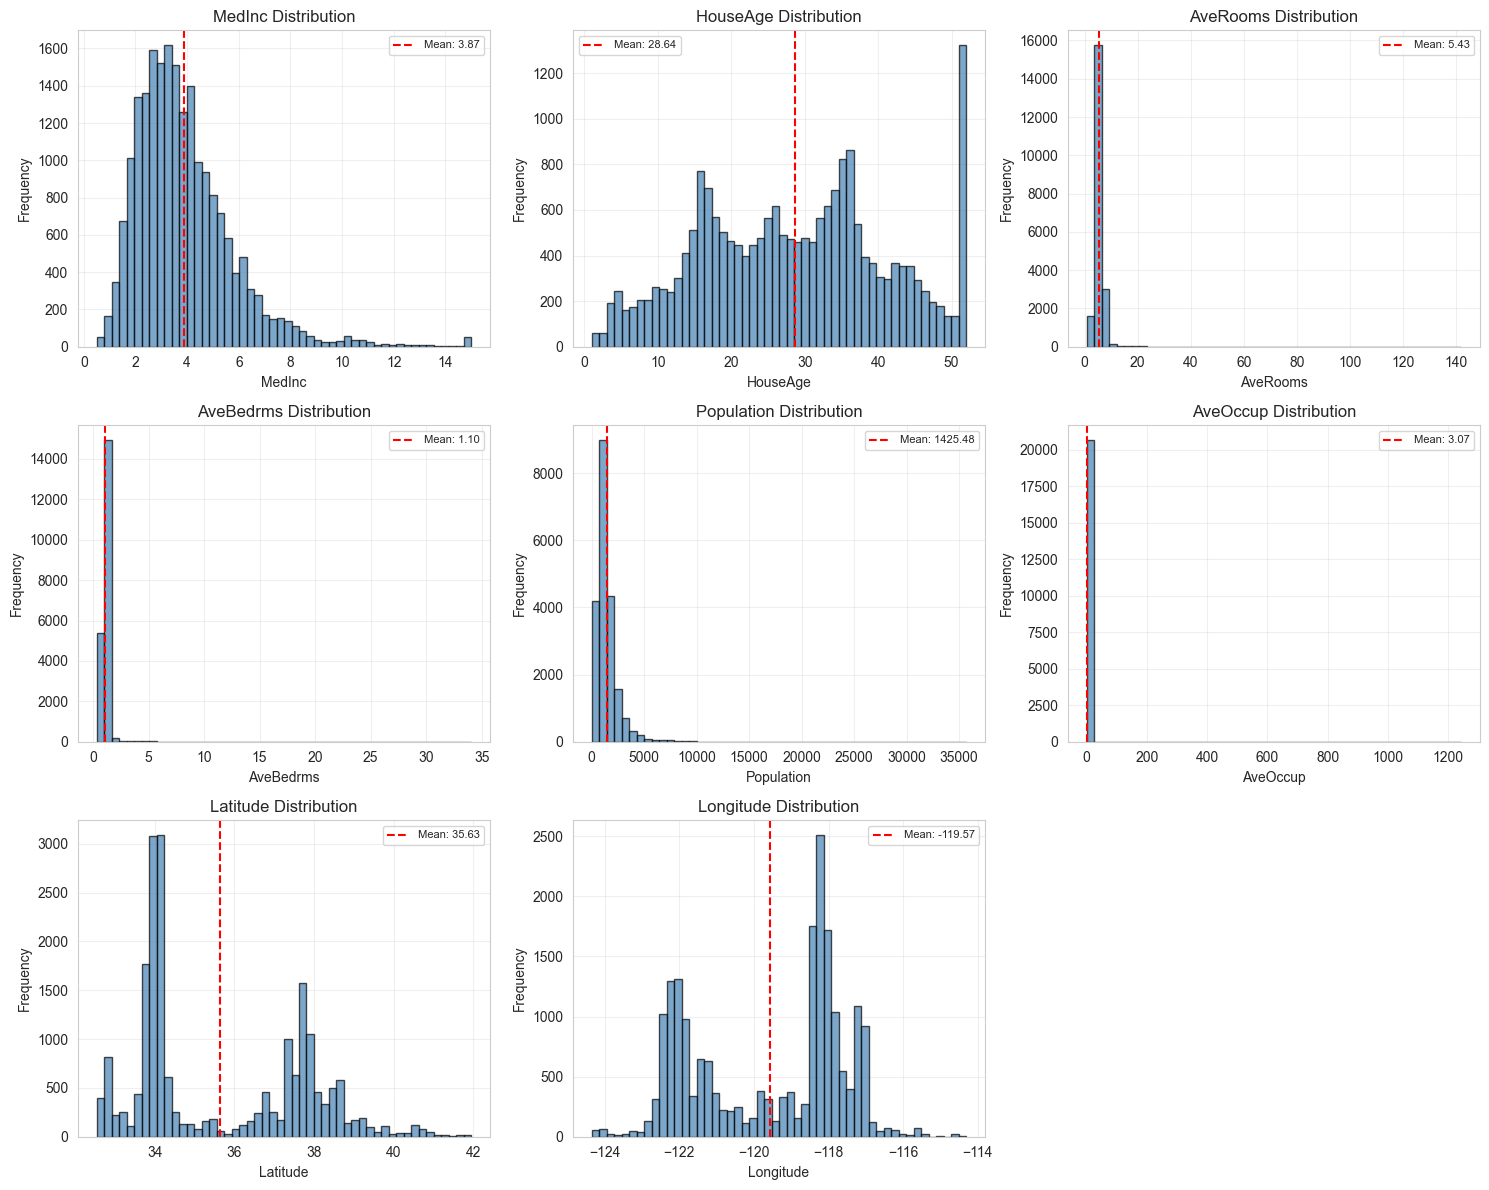

💡 Feature distribution observations:
  - MedInc: Right-skewed (few very high income areas)
  - HouseAge: Fairly uniform distribution
  - AveRooms: Right-skewed (some very large houses)
  - Latitude/Longitude: Reflect California's geography
  - Population: Heavy right skew (some very dense areas)


In [29]:
# Visualize feature distributions
# All features are numeric in California Housing dataset
numeric_cols = feature_cols

# Plot histograms for all numeric features
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].grid(True, alpha=0.3)
    
    # Add mean line
    mean_val = df[col].mean()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, 
                      label=f'Mean: {mean_val:.2f}')
    axes[idx].legend(fontsize=8)

# Hide extra subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("💡 Feature distribution observations:")
print("  - MedInc: Right-skewed (few very high income areas)")
print("  - HouseAge: Fairly uniform distribution")
print("  - AveRooms: Right-skewed (some very large houses)")
print("  - Latitude/Longitude: Reflect California's geography")
print("  - Population: Heavy right skew (some very dense areas)")

**Reading the output:**

The 3×3 histogram grid shows each feature's distribution. Key observations:

- **MedInc:** Right-skewed with a long tail — most block groups have median incomes between \$20k–\$60k, but a few exceed \$100k. Since this is the strongest predictor of house value, its skew may warrant a log transform in advanced modeling.
- **HouseAge:** Roughly uniform between 1–52 years, with a noticeable spike at 52 (the census cap for older housing stock).
- **AveRooms and AveBedrms:** Concentrated near 4–6 rooms and ~1 bedroom ratio, but with extreme right tails. The outliers (100+ average rooms) are artifacts of block groups with very few households, where a single large property skews the average.
- **Population:** Heavy right skew — most block groups have fewer than 2,000 residents, but a handful exceed 10,000–35,000.
- **AveOccup:** Tightly concentrated around 2–4 people per household, with rare extreme outliers (1,000+) from the same small-population artifact.
- **Latitude and Longitude:** Multimodal patterns reflecting California's population clusters — peaks near latitude ~34° (Los Angeles metro) and ~37.5° (San Francisco Bay Area), with longitude clustered around -118° and -122°.

**Implications for preprocessing:** The heavy skew in MedInc, Population, AveRooms, and AveOccup suggests that outlier handling (capping or winsorization) and/or log transforms may improve model performance. These decisions will be addressed in **upcoming notebooks**.

---

### 6.6 Correlation Analysis

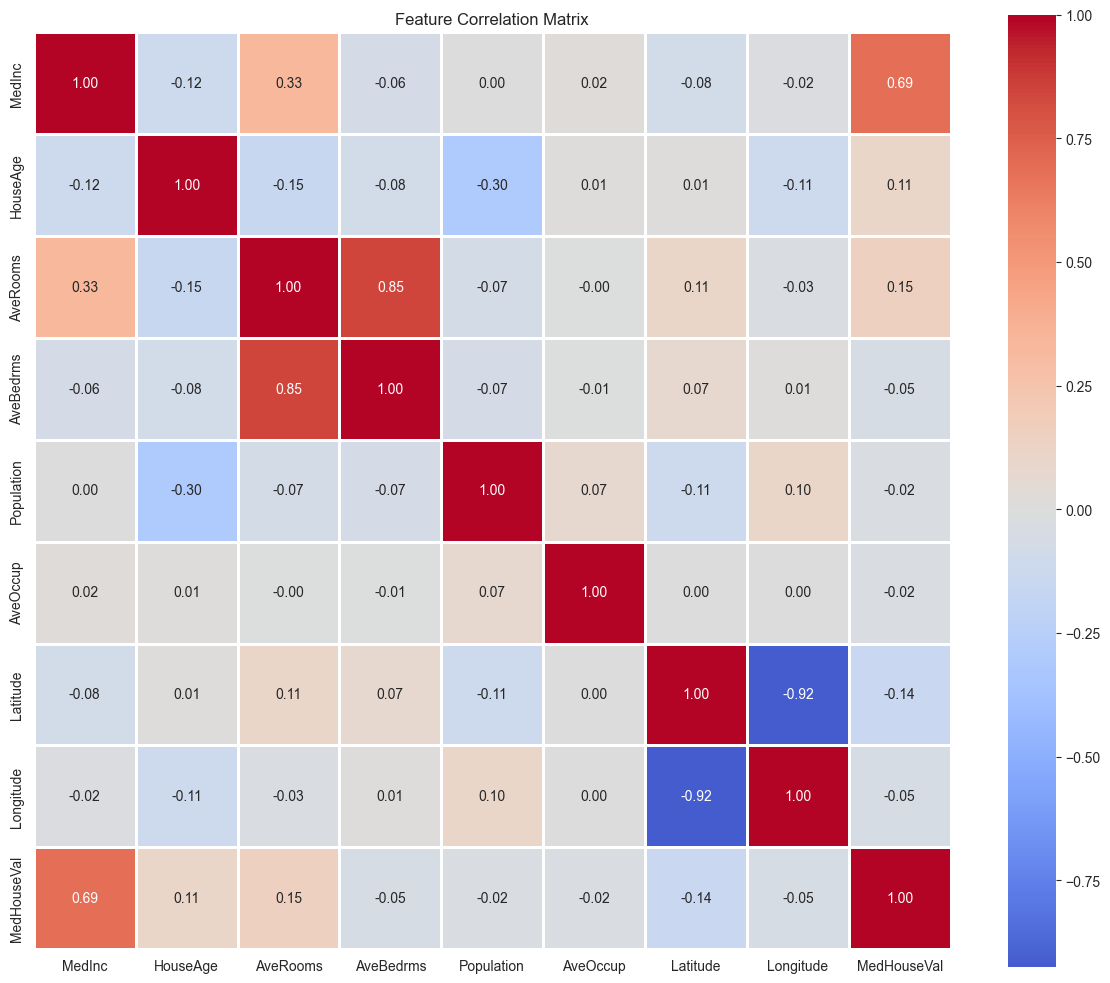


=== CORRELATIONS WITH TARGET ===
MedHouseVal    1.000
MedInc         0.688
AveRooms       0.152
HouseAge       0.106
AveOccup      -0.024
Population    -0.025
Longitude     -0.046
AveBedrms     -0.047
Latitude      -0.144
Name: MedHouseVal, dtype: float64


In [30]:
# Correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            square=True, linewidths=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Correlations with target
print("\n=== CORRELATIONS WITH TARGET ===")
target_corr = corr_matrix[target_col].sort_values(ascending=False)
print(target_corr)

**Reading the output:**

The heatmap and the sorted correlation table reveal the linear relationships between all variable pairs:

- **Strongest predictor:** MedInc has the highest positive correlation with MedHouseVal (**r ≈ 0.69**). Median income is by far the single best linear predictor of house value — this aligns with the economic intuition that wealthier neighborhoods have more expensive homes.
- **Moderate predictors:** AveRooms (r ≈ 0.15) shows a weak positive link (larger homes cost more), while Latitude (r ≈ -0.14) shows a weak negative link (southern California tends toward higher values, likely reflecting the Los Angeles metro premium).
- **Multicollinearity flag:** AveRooms and AveBedrms are highly correlated with each other (**r ≈ 0.85**). This means they carry largely redundant information. While this doesn't cause problems for tree-based models, it can inflate coefficient variance in linear regression. Regularized models (Ridge, LASSO) will handle this automatically.
- **No leakage signal:** No feature has a suspiciously high correlation (r > 0.95) with the target, which is reassuring — there are no obvious leakage red flags from the correlation structure alone.

**Key takeaway for modeling:** MedInc will likely dominate any linear model. To capture the remaining predictive signal, we'll need to leverage geographic features (Latitude/Longitude) and potentially non-linear methods (trees, ensembles) that can exploit interaction patterns that correlations alone don't reveal.

---

## 7. Train/Validation/Test Splits + Leakage Prevention

### 7.1 Why Three Splits?

- **Train set**: Used to fit models
- **Validation set**: Used to tune hyperparameters and compare models
- **Test set**: Final "lockbox" evaluation - touch only once at the end

### 7.2 Creating Reproducible Splits

> **⚠️ Critical Rule:** Always split data BEFORE any preprocessing to avoid leakage.

In [31]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split: 60% train, 20% validation, 20% test
# For regression, we don't need stratification (that's for classification)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_SEED  # 0.25 * 0.80 = 0.20
)

print("\n=== SPLIT SIZES ===")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")
print(f"Total: {len(X_train) + len(X_val) + len(X_test)} samples")

# Check target distribution across splits
print("\n=== TARGET DISTRIBUTION ACROSS SPLITS ===")
print(f"Train - Mean: ${y_train.mean():.2f}00k, Std: ${y_train.std():.2f}00k")
print(f"Val   - Mean: ${y_val.mean():.2f}00k, Std: ${y_val.std():.2f}00k")
print(f"Test  - Mean: ${y_test.mean():.2f}00k, Std: ${y_test.std():.2f}00k")

print("\n✓ Data successfully split into train/validation/test sets")
print(f"✓ Using RANDOM_SEED = {RANDOM_SEED} for reproducibility")

Features shape: (20640, 8)
Target shape: (20640,)

=== SPLIT SIZES ===
Train: 12384 samples (60.0%)
Validation: 4128 samples (20.0%)
Test: 4128 samples (20.0%)
Total: 20640 samples

=== TARGET DISTRIBUTION ACROSS SPLITS ===
Train - Mean: $2.0600k, Std: $1.1500k
Val   - Mean: $2.0600k, Std: $1.1600k
Test  - Mean: $2.1000k, Std: $1.1600k

✓ Data successfully split into train/validation/test sets
✓ Using RANDOM_SEED = 474 for reproducibility


### 7.3 Split Sanity Checks

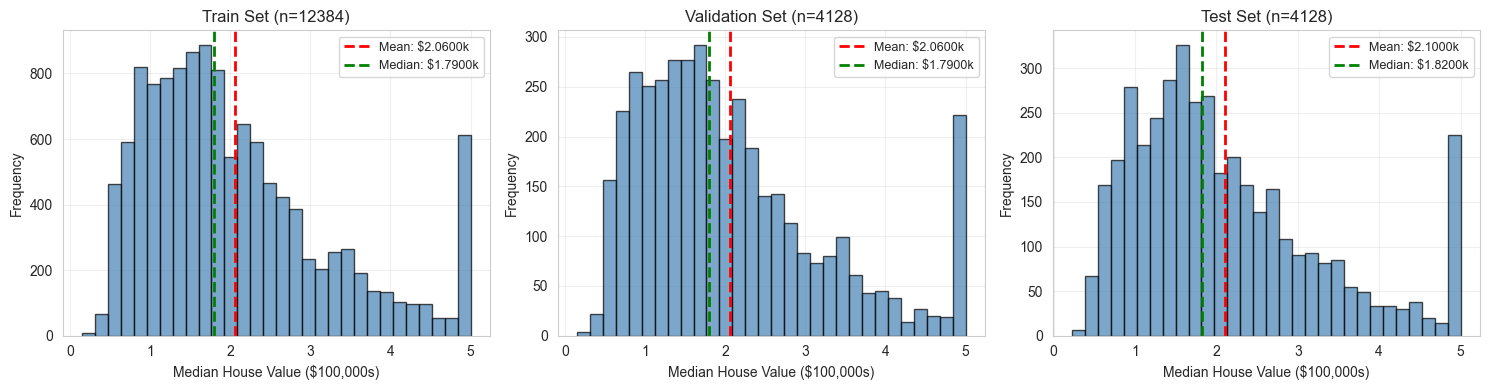

=== DISTRIBUTION CONSISTENCY CHECK ===
Train - Mean: $2.06100k, Median: $1.79200k
Val   - Mean: $2.05900k, Median: $1.79300k
Test  - Mean: $2.10100k, Median: $1.82400k

✓ Target distributions are similar across splits
✓ Random splitting preserves overall data characteristics


In [32]:
# Visualize target distribution across splits (regression)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (split_name, split_y) in enumerate([('Train', y_train), ('Validation', y_val), ('Test', y_test)]):
    axes[idx].hist(split_y, bins=30, alpha=0.7, edgecolor='black', color='steelblue')
    axes[idx].axvline(split_y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${split_y.mean():.2f}00k')
    axes[idx].axvline(split_y.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${split_y.median():.2f}00k')
    axes[idx].set_xlabel('Median House Value ($100,000s)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{split_name} Set (n={len(split_y)})')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== DISTRIBUTION CONSISTENCY CHECK ===")
print(f"Train - Mean: ${y_train.mean():.3f}00k, Median: ${y_train.median():.3f}00k")
print(f"Val   - Mean: ${y_val.mean():.3f}00k, Median: ${y_val.median():.3f}00k")
print(f"Test  - Mean: ${y_test.mean():.3f}00k, Median: ${y_test.median():.3f}00k")
print("\n✓ Target distributions are similar across splits")
print("✓ Random splitting preserves overall data characteristics")

### 7.4 Leakage Sniff Test

**Common leakage patterns to watch for:**

1. **Target leakage**: Features that contain information from the future or are derived from the target
2. **Test set contamination**: Using test data to make preprocessing or modeling decisions
3. **Time-based leakage**: Using future data to predict the past
4. **Preprocessing leakage**: Fitting transformers on the full dataset before splitting

In [33]:
# Leakage checklist
print("=== LEAKAGE SNIFF TEST ===")
print("\n✓ Checklist:")
print("  [✓] Split data before any preprocessing")
print("  [✓] No overlap between train/val/test indices")
print("  [✓] Random splitting ensures fair distribution for regression")
print("  [✓] Check feature descriptions for suspicious variables")
print("  [✓] Verify no future information in features")
print("  [✓] Confirm target is not derived from features")

print("\n=== FEATURE NAMES ===")
print("Review these carefully for potential leakage:")
for col in X.columns:
    print(f"  - {col}")

print("\n⚠️ Red flags to watch for:")
print("  - Features with 'target', 'outcome', 'label', 'price', 'value' in name")
print("  - Perfect correlations (r > 0.99)")
print("  - Features that would not be available at prediction time")
print("  - ID columns that encode information about the target")

# Check for suspiciously high correlations
high_corr = []
for col in X.columns:
    if col in corr_matrix.columns and target_col in corr_matrix.columns:
        corr_val = abs(corr_matrix.loc[col, target_col])
        if corr_val > 0.95:
            high_corr.append((col, corr_val))

if high_corr:
    print("\n⚠️ WARNING: Suspiciously high correlations detected:")
    for col, corr_val in high_corr:
        print(f"  - {col}: r = {corr_val:.3f}")
        print(f"    → This could indicate leakage - investigate further!")
else:
    print("\n✓ No suspiciously high correlations (r > 0.95) detected")
    print(f"\n💡 Strongest correlation with target: {corr_matrix[target_col].drop(target_col).abs().idxmax()} (r = {corr_matrix[target_col].drop(target_col).abs().max():.3f})")

=== LEAKAGE SNIFF TEST ===

✓ Checklist:
  [✓] Split data before any preprocessing
  [✓] No overlap between train/val/test indices
  [✓] Random splitting ensures fair distribution for regression
  [✓] Check feature descriptions for suspicious variables
  [✓] Verify no future information in features
  [✓] Confirm target is not derived from features

=== FEATURE NAMES ===
Review these carefully for potential leakage:
  - MedInc
  - HouseAge
  - AveRooms
  - AveBedrms
  - Population
  - AveOccup
  - Latitude
  - Longitude

⚠️ Red flags to watch for:
  - Features with 'target', 'outcome', 'label', 'price', 'value' in name
  - Perfect correlations (r > 0.99)
  - Features that would not be available at prediction time
  - ID columns that encode information about the target

✓ No suspiciously high correlations (r > 0.95) detected

💡 Strongest correlation with target: MedInc (r = 0.688)


## 📝 PAUSE-AND-DO Exercise 1 (10 minutes)

**Task:** Complete the EDA checklist on the dataset and summarize 3 key findings.

**Instructions:**
1. Review all the EDA outputs above
2. Identify 3 important patterns or insights
3. Write your findings in the cell below

**What to look for:**
- Unusual distributions
- Strong correlations
- Potential data quality issues
- Features that might be useful predictors

---

### YOUR FINDINGS HERE:

**Finding 1:**  
[Your observation about the data - e.g., target distribution, feature ranges, correlations with price]

**Finding 2:**  
[Your second observation - e.g., relationship between income and house value, geographic patterns, outliers]

**Finding 3:**  
[Your third observation - e.g., feature correlations, missing values (there are none!), data quality]

**Example observations to look for:**
- Is MedInc strongly correlated with MedHouseVal?
- Do coastal areas (certain Latitude/Longitude combinations) have higher prices?
- Are there outliers in AveRooms or AveOccup that might need handling?
- Is the target variable skewed?

---

## 📝 PAUSE-AND-DO Exercise 2 (10 minutes)

**Task:** Review the dataset and identify 3 potential leakage risks for real estate prediction.

**Instructions:**
1. Think about the business context (California housing price prediction)
2. Review the feature names and their correlations with the target
3. Identify 3 scenarios or features that could cause leakage
4. Explain why each would be problematic

**Consider:**
- Would this feature be available at prediction time?
- Could this feature encode information about the outcome?
- Is this feature derived from or influenced by the target?

---

### YOUR LEAKAGE ANALYSIS HERE:

**Potential Risk 1:**  
[Describe a feature or scenario that could cause leakage in a real estate prediction context]

**Potential Risk 2:**  
[Describe another leakage risk - think about temporal ordering, feature availability]

**Potential Risk 3:**  
[Describe a preprocessing or data handling issue that could cause train-test contamination]

**Examples to consider for real estate prediction:**
- Would "recent sale price" be available at prediction time? (NO - that's the target!)
- Would "current listing price" be available? (Maybe, but that would leak target information)
- Could "neighborhood average sale price" leak information about specific property values?
- What about "appraised value"? (Definitely leakage - that's essentially the target)
- Time-based features: Are we using data from the future to predict the past?
- Preprocessing: Did we normalize using statistics from the full dataset before splitting?

---

## 8. Wrap-Up: Key Takeaways

### What We Learned Today:

1. **Colab Workflow**: How to use Google Colab and responsible AI assistance with Gemini (Ask → Verify → Document)
2. **Predictive Analytics Fundamentals**: Statistical learning framework, supervised vs. unsupervised, $Y = f(X) + \epsilon$
3. **End-to-End Workflow**: 9-step process from data loading to model deployment
4. **Data Leakage**: Target leakage vs. train-test contamination, and how to prevent both
5. **Train vs. Test Error**: Why training error is misleading and we need validation
6. **Curse of Dimensionality**: Why more features isn't always better
7. **Flexibility vs. Interpretability**: Choosing models based on goals and constraints
8. **Bias-Variance Trade-off**: The fundamental concept underlying all model selection
9. **EDA Essentials**: Data types, missingness, distributions, correlations
10. **Proper Splitting**: Train/val/test splits with stratification and reproducible seeds

### Next-Class Readiness:

- ✓ You can load and explore a dataset in Google Colab
- ✓ You can identify non-feature columns and potential leakage risks
- ✓ You can create proper train/val/test splits with reproducible seeds
- ✓ You understand why we split before preprocessing
- ✓ You're ready for the next notebook: Preprocessing Pipelines

### Remember:

> **"Split first, preprocess second, model third"**  
> This order prevents leakage and ensures valid evaluation.

> **"Understand the bias-variance trade-off"**  
> Every modeling decision balances these two sources of error.

> **"Use Gemini responsibly"**  
> Ask → Verify → Document. You own all code you submit.

---

## 9. Participation Assignment Submission Instructions

### To Submit This Notebook:

1. **Complete all exercises**: Fill in both PAUSE-AND-DO exercise cells with your findings
2. **Run All Cells**: Execute `Runtime → Run all` to ensure everything works
3. **Save a Copy**: `File → Save a copy in Drive`
4. **Submit**: Upload your `.ipynb` file in the participation assignment you find in the course Brightspace page.

### Before Submitting, Check:

- [ ] All cells execute without errors
- [ ] All outputs are visible
- [ ] Both exercise responses are complete
- [ ] Notebook is shared with correct permissions
- [ ] You can explain every line of code you wrote

### Next Step:

Complete the **Quiz** in Brightspace (auto-graded)

---

## Bibliography

- James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). *An Introduction to Statistical Learning with Python* (ISLP), Chapter 2. Springer. https://www.statlearning.com/
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning* (ESL), Chapter 2. Springer.
- Kaggle. (2023). *Data Leakage Tutorial*. https://www.kaggle.com/code/alexisbcook/data-leakage
- scikit-learn User Guide: [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
- scikit-learn User Guide: [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)
- Google Colab Documentation: https://colab.research.google.com/

---


<center>

Thank you!

</center>
